In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
%aimport vae
%aimport distributions
%aimport y_utils
%aimport samplers
from y_utils import *
from vae import VAE
from samplers import *
from distributions import Banana, Funnel
import torch
from matplotlib import pyplot as plt
import numpy as np
import time

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)

device: cuda


In [4]:
Ds = [2, 4, 8, 12, 16, 24, 32]
targets = [Banana(dim=D, sigma=5.0, b=0.02, device=device) for D in Ds]

In [5]:
def get_model(D):
    hidden_dims = (128, 128, 128, 128)
    latent_dim = D
    return VAE(data_dim=D, hidden_dims=hidden_dims, latent_dim=latent_dim, device=device)

IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 4)

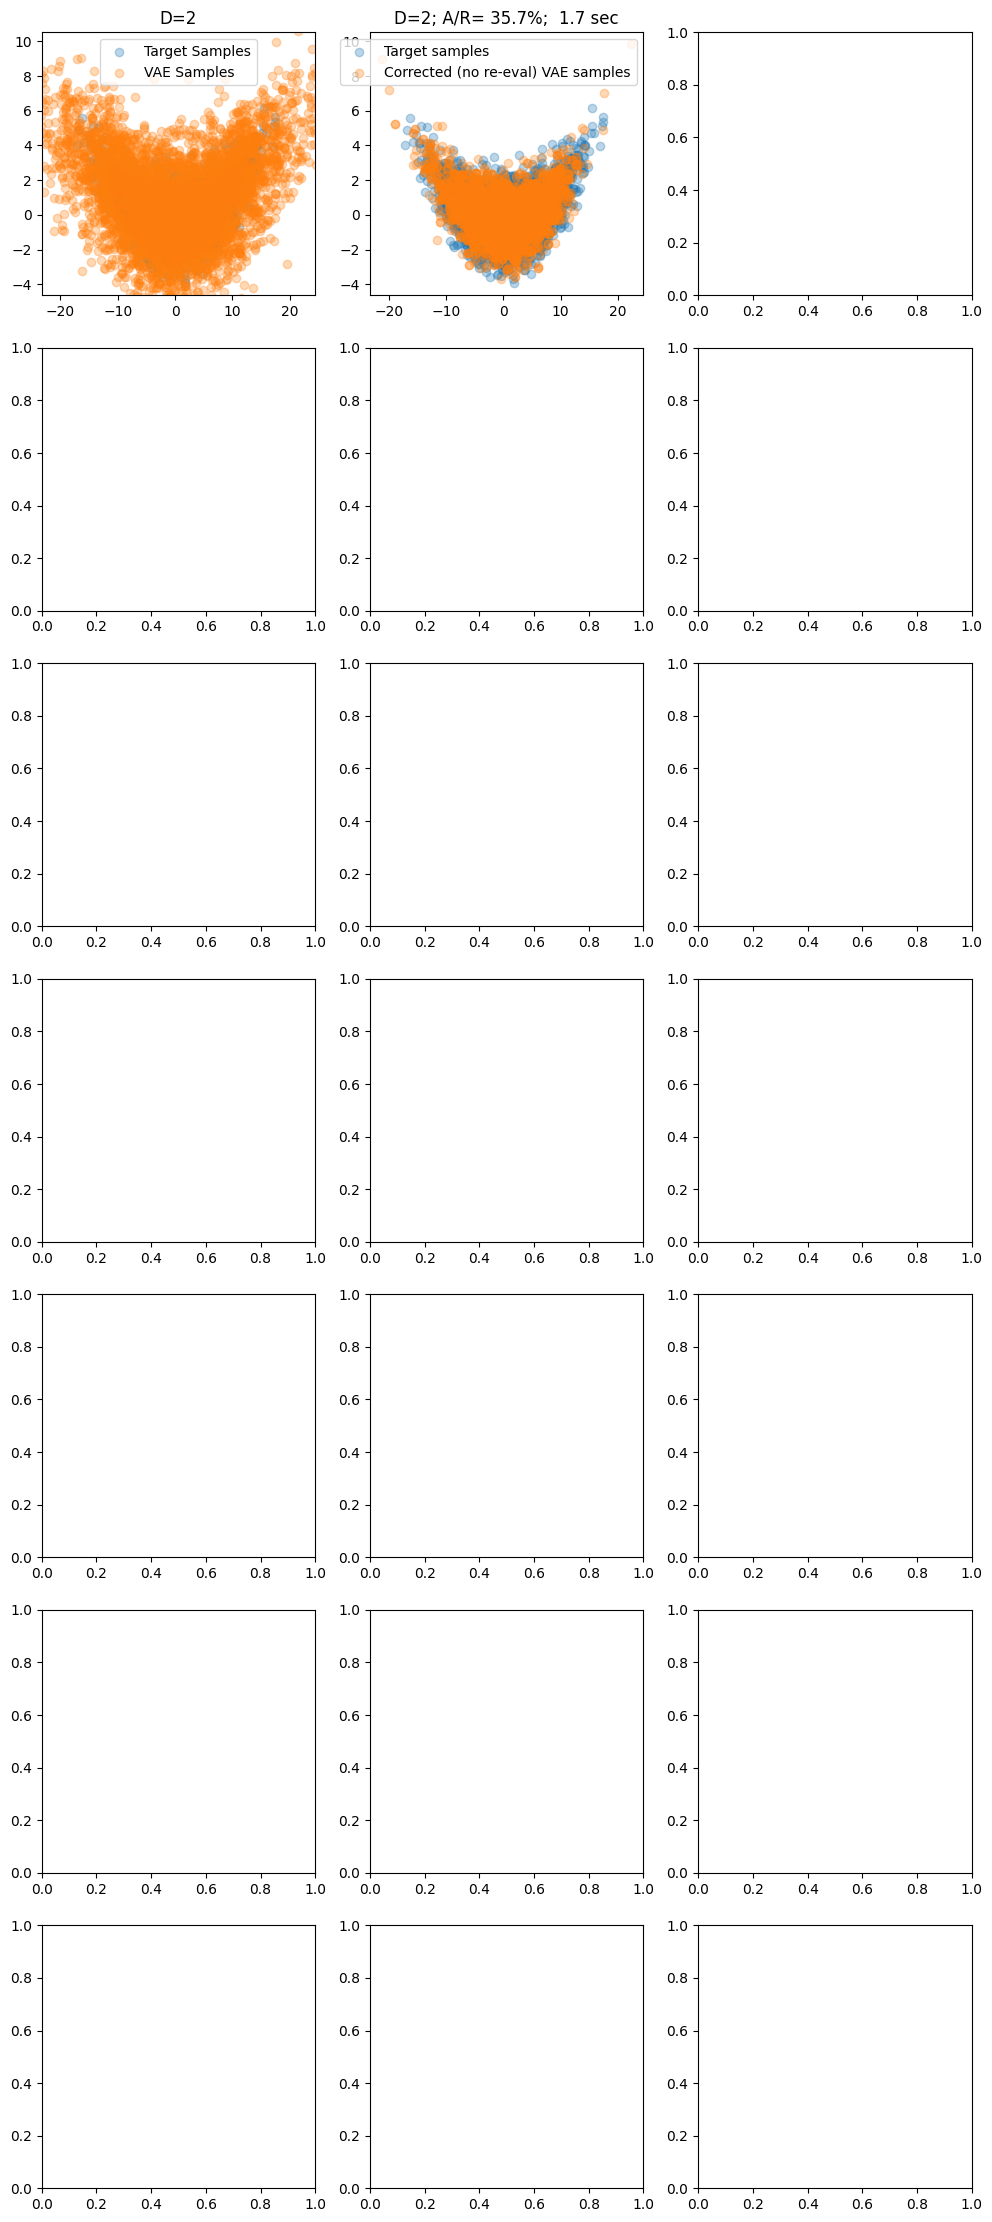

In [6]:
%%time

def plot_mh_samples_for_all_Ds(use_reeval=False, use_multiple=False):
    std_factor = 2
    N = 5000
    L = 64
    proj_dims = (0, 1)

    ncols = 2 + use_reeval + use_multiple
    nrows = len(Ds)
    fig, axss = plt.subplots(ncols=ncols, nrows=nrows, figsize=(4 * ncols, 4 * nrows))
    alpha = 0.3
    
    for D, target, axs in zip(Ds, targets, axss):
        model = get_model(D)
        model.load_knowledge(f'models/{model}_banana.pt')
        model.set_std_factor(std_factor)
        proposer = lambda sample_shape : model.sample(sample_shape)
        proposal_log_prob_estimator = lambda x : model.iw_log_marginal_estimate(x, L=L, batch_L=32)
        
        _time1 = time.time()
        acc_rate1, mh_samples = approximate_metropolis_hastings(target, proposer, proposal_log_prob_estimator, n_samples=N)
        _time2 = time.time()
        if use_reeval:
            acc_rate2, mh_samples_reeval = approximate_metropolis_hastings_reevaluation(target, proposer, proposal_log_prob_estimator, n_samples=N)
        _time3 = time.time()
        mh_time = _time2 - _time1
        mh_reeval_time =  _time3 - _time2
        
        target_samples = target.sample((N,))
        vae_samples = proposer((N,))
        
        ax1 = axs[0]
        ax2 = axs[1]
        

        ax2.scatter(*pl(target_samples[:, proj_dims]), alpha=alpha, label='Target samples')
        ax2.scatter(*pl(mh_samples[:, proj_dims]), alpha=alpha, label='Corrected (no re-eval) VAE samples')
        ax2.legend()
        ax2.set_title(f'D={D}; A/R={100 * acc_rate1: 0.1f}%; {mh_time: 0.1f} sec')
        #ax2.set_xticks([])
        #ax2.set_yticks([])
        
        ax1.scatter(*pl(target_samples[:, proj_dims]), alpha=alpha, label='Target Samples')
        ax1.scatter(*pl(vae_samples[:, proj_dims]), alpha=alpha, label='VAE Samples')
        ax1.set_title(f'D={D}')
        ax1.legend()
        ax1.set_xlim(ax2.get_xlim())
        ax1.set_ylim(ax2.get_ylim())
        #ax1.set_xticks([])
        #ax1.set_yticks([])

        if use_reeval:
            ax3 = axs[2]
            ax3.scatter(*pl(target_samples[:, proj_dims]), alpha=alpha, label='Target Samples')
            ax3.scatter(*pl(mh_samples_reeval[:, proj_dims]), alpha=alpha, label='Corrected (w/re-eval) VAE samples')
            ax3.legend()
            ax3.set_title(f'D={D}; A/R={100 * acc_rate2: 0.1f}%; {mh_reeval_time: 0.1f} sec')
            ax3.set_xlim(ax2.get_xlim())
            ax3.set_ylim(ax2.get_ylim())
            ax3.set_xticks([])
            ax3.set_yticks([])

        if use_multiple:
            n_estimates = 2
            acc_rate, mh_samples_multiple = approximate_metropolis_hastings_multiple_estimates(target, proposer, proposal_log_prob_estimator, n_estimates=n_estimates, n_samples=N)
            
            ax4 = axs[2 + use_reeval]
            ax4.scatter(*pl(target_samples[:, proj_dims]), alpha=alpha, label='Target Samples')
            ax4.scatter(*pl(mh_samples_multiple[:, proj_dims]), alpha=alpha, label=f'Corrected ({n_estimates} estimates) VAE samples')
            ax4.legend()
            ax4.set_title(f'D={D}; A/R={100 * acc_rate: 0.1f}%')
            ax4.set_xlim(ax2.get_xlim())
            ax4.set_ylim(ax2.get_ylim())
    
        plt.suptitle(f'MH Correction of VAE Samples (Projections)\n std_factor={std_factor}; L={L}; {N} samples', y=1.0)
        fig.tight_layout()

plot_mh_samples_for_all_Ds(use_reeval=False, use_multiple=True)

CPU times: total: 24.1 s
Wall time: 20.8 s


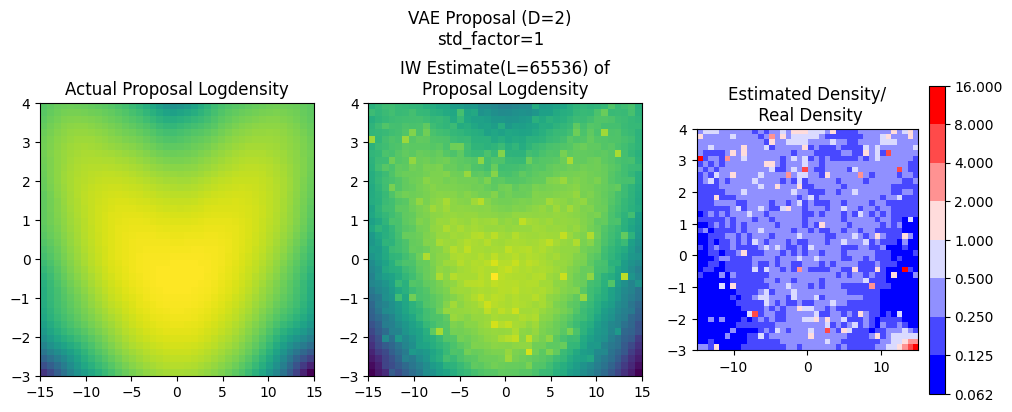

In [7]:
%%time

from scipy.stats import gaussian_kde
from matplotlib.colors import TwoSlopeNorm
import matplotlib.colors as mcolors

def evaluate_iw_proposal_estimator_2d():
    std_factor = 1
    L = 65_536
    
    model = get_model(2)
    model.load_knowledge(f'models/{model}_banana.pt')
    model.set_std_factor(std_factor)
    target = targets[0]
    
    N = 20000  # points for kde
    model_samples = to_numpy(model.sample((N, )))
    proposal_kernel = gaussian_kde(model_samples.T, bw_method='scott')
    proposal_kernel.set_bandwidth(proposal_kernel.factor * 1.5)
    proposal_log_estimate = lambda x: to_numpy(model.iw_log_marginal_estimate(torch.tensor(x.T, dtype=torch.float).to(device), L=L, batch_L=512))
    
    xlim = (-15, 15)
    ylim = (-3, 4)
    d = 40
    x = np.linspace(*xlim, d)
    y = np.linspace(*ylim, d)
    X, Y = np.meshgrid(x, y)
    points = np.vstack((X.ravel(), Y.ravel()))

    real_logd = proposal_kernel.logpdf(points).reshape(d, d)
    estimated_logd = proposal_log_estimate(points).reshape(d, d)
    target_logd = target.log_prob(points.T).reshape(d, d)
    
    ratio = (xlim[1] - xlim[0]) / (ylim[1] - ylim[0])
    fig, axs = plt.subplots(ncols=3, figsize=(12, 4))
    ax1 = axs[0]
    ax2 = axs[1]
    ax3 = axs[2]
    #ax4 = axs[3]
    
    img1 = ax1.imshow(real_logd, origin='lower', extent=[*xlim, *ylim])
    ax1.set_aspect(ratio)
    ax1.set_title(f'Actual Proposal Logdensity')
    
    img2 = ax2.imshow(estimated_logd, origin='lower', extent=[*xlim, *ylim])
    ax2.set_aspect(ratio)
    ax2.set_title(f'IW Estimate(L={L}) of\nProposal Logdensity')

    Z = estimated_logd - real_logd
    #vmin = Z.min()
    #vmax = Z.max()
    #vcenter = 0
    #norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
    boundaries = np.log(np.array([1/16, 1/8, 1/4, 1/2, 1, 2, 4, 8, 16]))
    cmap = plt.get_cmap('bwr')
    norm = mcolors.BoundaryNorm(boundaries=boundaries, ncolors=cmap.N, clip=True)
    img3 = ax3.imshow(Z, cmap=cmap, norm=norm, origin='lower', extent=[*xlim, *ylim])
    #ax2.set_xticks([])
    #ax2.set_yticks([])
    ax3.set_aspect(ratio)
    ax3.set_title(f'Estimated Density/\n Real Density')
    cbar = fig.colorbar(img3, ax=ax3, orientation='vertical', pad=0.04)
    #ticks = [0.01, 0.05, 0.25, 1, 1.1, 2, 4, 8]
    #cbar.set_ticks([np.log(x) for x in ticks])
    cbar.set_ticklabels([f'{(np.exp(val)):.3f}' for val in cbar.get_ticks()])
    '''
    Z = target_logd - estimated_logd
    img4 = ax4.imshow(Z, origin='lower', extent=[*xlim, *ylim])
    #ax2.set_xticks([])
    #ax2.set_yticks([])
    ax4.set_aspect(ratio)
    ax4.set_title(f'Target Density /\n Estimaed Proposal Density')
    cbar = fig.colorbar(img4, ax=ax4, orientation='vertical', pad=0.04)
    '''
    fig.suptitle(f'VAE Proposal (D=2)\nstd_factor={std_factor}', y=1.07)
    

evaluate_iw_proposal_estimator_2d()